# Time series plots for small domain quantities

In [1]:
import xarray as xr
import numpy as np
import glob
import proplot as plot

In [2]:
cases = ['nz_32','nz_64','nz_128','nz_256']

# where files are located
fpath = 

# where to save figures
figpath = 

# colormap
cmap =  np.asarray([
                        [211, 62, 67, 255],
                        [248, 196, 98, 255],
                        [152, 193, 217, 255],
                        [64, 72, 119, 255]])/255

nx = 128
ny = 128

### Load variables from STAT files

In [3]:
iwp = []
qlw = []
qsw = []
hf = []
pw = []
hint_var = []
precip_5day = []

dt = []
for icase,case in enumerate(cases):
    ds = xr.open_dataset(glob.glob(fpath + case + '/OUT_STAT/*.nc')[0])

    integer_days = np.floor(ds.time*2)/2
    
    ds = ds.groupby(integer_days).mean('time')
    
    dt.append((ds.time[1]-ds.time[0]).values * 24) # hours
    
    iwp.append(ds.IWP.load())
    qsw.append((ds.SWNTOA - ds.SWNS).load())
    qlw.append((ds.LWNS - ds.LWNTOA).load())
    hf.append((ds.SHF + ds.LHF).load())
    pw.append(ds.PW.load())
    
    precip_5day.append(ds.PREC.rolling(center=True, time=10).mean())
    
    # Calculate the spatial variance of frozen MSE
    files = np.sort(glob.glob(fpath + case + '/OUT_3D/FMSE/*.nc'))
    hint = xr.open_mfdataset(files).fmse_vint
    hint_var.append(hint.var(dim=('x','y')).load())

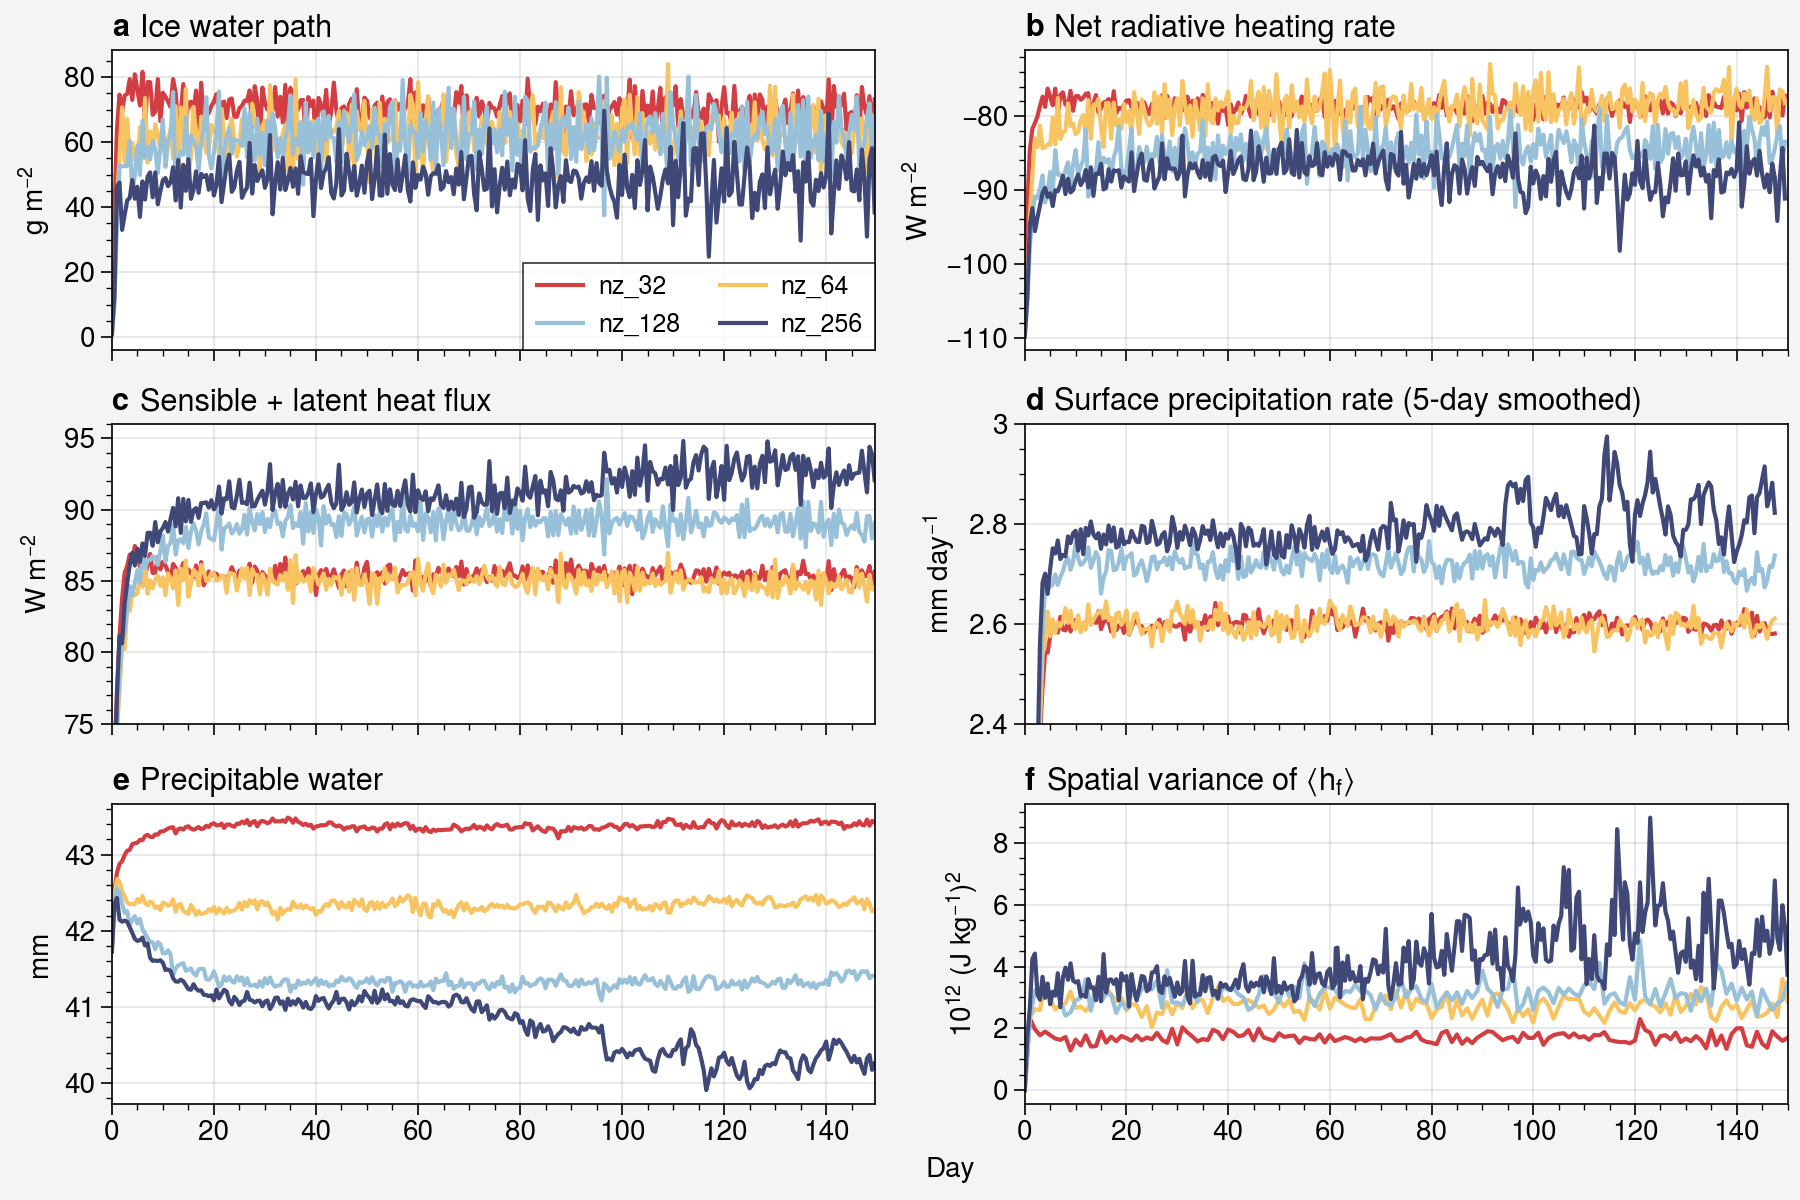

In [5]:
# Plot

fig, ax = plot.subplots(nrows=3, ncols=2,sharex=3,sharey=0,width=9,height=6)

ax.format(fontsize=10,abc=True,titleloc='l')

for icase,case in enumerate(cases):
    
    window = int(0.5 + 24/dt[icase])
    window2 = int(24/((hint_var[icase].time[1]-hint_var[icase].time[0]).values * 24) + 0.5)
    
    # ax[0].plot(iwp[icase].time, iwp[icase].rolling(time=window,center=True).mean(),
    ax[0].plot(iwp[icase].time, iwp[icase], color=cmap[icase],label=case)
    ax[1].plot(qlw[icase].time, qlw[icase] + qsw[icase], color=cmap[icase])
    ax[2].plot(hf[icase].time, hf[icase], color=cmap[icase])
    ax[3].plot(precip_5day[icase].time,precip_5day[icase], color=cmap[icase])
    ax[4].plot(pw[icase].time, pw[icase], color=cmap[icase])
    ax[5].plot(hint_var[icase].time,1e-12*hint_var[icase], color=cmap[icase])
    
ax[0].legend(ncol=2,loc='lr')

ax[0].format(xlabel='Day',title='Ice water path',
             ylabel='g m$^{-2}$') 
ax[1].format(title='Net radiative heating rate',
             ylabel='W m$^{-2}$') 
ax[2].format(title='Sensible + latent heat flux',
             ylabel='W m$^{-2}$',ylim=(75,96)) 
ax[3].format(title='Surface precipitation rate (5-day smoothed)',
             ylabel='mm day$^{-1}$', ylim=(2.4,3)) 
ax[4].format(title='Precipitable water',
             ylabel='mm') 
ax[5].format(title='Spatial variance of ' + r'$\langle h_f \rangle$',
             ylabel='10$^{12}$ (J kg$^{-1}$)$^2$')

fig.savefig(figpath + 'small-domain-timeseries.png',dpi=300)